# Laboratorio 3. Análisis GeoEspacial y Sensores Remotos
- Fabiola Contreras 22787
- María José Villafuerte 22129

## Carga de datos y NVDI

In [1]:
import rasterio
from rasterio.warp import reproject, Resampling
import numpy as np

def alinear_raster(origen_array, origen_meta, destino_meta):
    # Crear un array vacío con el tamaño del destino
    destino_array = np.empty((destino_meta['height'], destino_meta['width']), dtype=origen_array.dtype)

    reproject(
        source=origen_array,
        destination=destino_array,
        src_transform=origen_meta['transform'],
        src_crs=origen_meta['crs'],
        dst_transform=destino_meta['transform'],
        dst_crs=destino_meta['crs'],
        resampling=Resampling.nearest
    )
    return destino_array

In [2]:
import rasterio
import numpy as np

def calcular_ndvi_archivos(archivo_nir, archivo_rojo):
    with rasterio.open(archivo_nir) as nir_src, rasterio.open(archivo_rojo) as rojo_src:
        nir = nir_src.read(1).astype("float32")
        rojo = rojo_src.read(1).astype("float32")
        perfil = nir_src.profile  # Guardamos perfil para exportar
    ndvi = (nir - rojo) / (nir + rojo + 1e-10)
    return ndvi, perfil

# Calcular NDVI para cada año (ejemplo: banda Rojo=4, banda NIR=8)
ndvi_2020, perfil_2020 = calcular_ndvi_archivos("2020-04/2020-04-06-00_00_2020-04-19-23_59_Sentinel-2_L2A_B08_(Raw).tiff", "2020-04/2020-04-06-00_00_2020-04-19-23_59_Sentinel-2_L2A_B04_(Raw).tiff")
ndvi_2024, perfil_2024      = calcular_ndvi_archivos("2024-04/2024-04-26-00_00_2024-05-06-23_59_Sentinel-2_L2A_B08_(Raw).tiff", "2024-04/2024-04-26-00_00_2024-05-06-23_59_Sentinel-2_L2A_B04_(Raw).tiff")

# Alinear NDVI 2024 al perfil del NDVI 2020
ndvi_2024_alineado = alinear_raster(ndvi_2024, perfil_2024, perfil_2020)

# Ahora sí, diferencia
ndvi_diff = ndvi_2024_alineado - ndvi_2020
umbral = -0.2
perdida = ndvi_diff < umbral

## Visualización

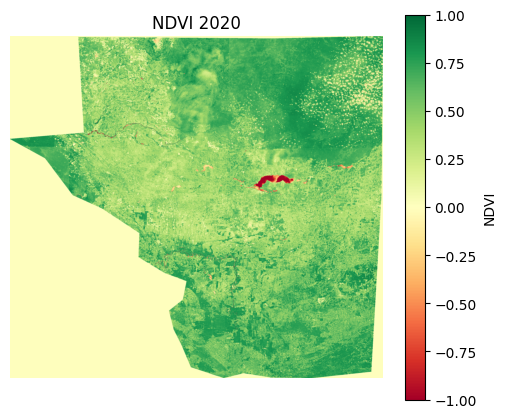

In [3]:
import matplotlib.pyplot as plt

# NDVI 2020
plt.figure(figsize=(6,5))
plt.imshow(ndvi_2020, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title("NDVI 2020")
plt.colorbar(label="NDVI")
plt.axis('off')
plt.show()

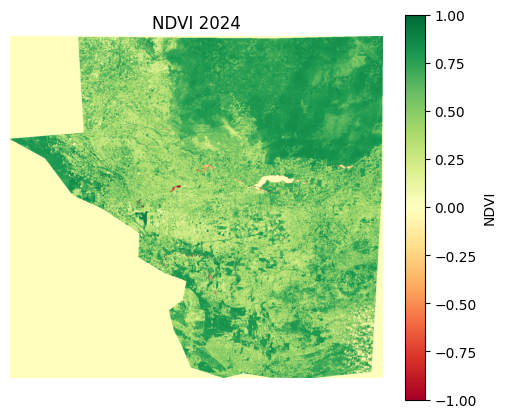

In [4]:
# NDVI 2024
plt.figure(figsize=(6,5))
plt.imshow(ndvi_2024, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title("NDVI 2024")
plt.colorbar(label="NDVI")
plt.axis('off')
plt.show()

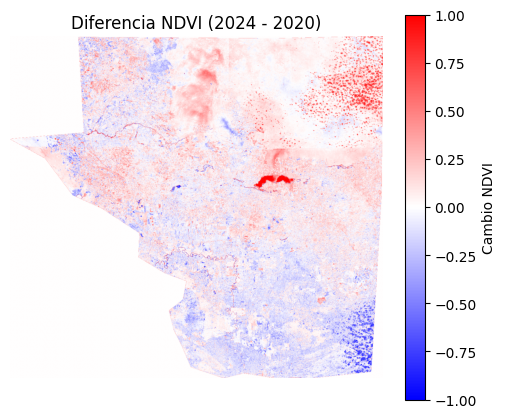

In [5]:
# Diferencia NDVI
plt.figure(figsize=(6,5))
plt.imshow(ndvi_diff, cmap='bwr', vmin=-1, vmax=1)
plt.title("Diferencia NDVI (2024 - 2020)")
plt.colorbar(label="Cambio NDVI")
plt.axis('off')
plt.show()

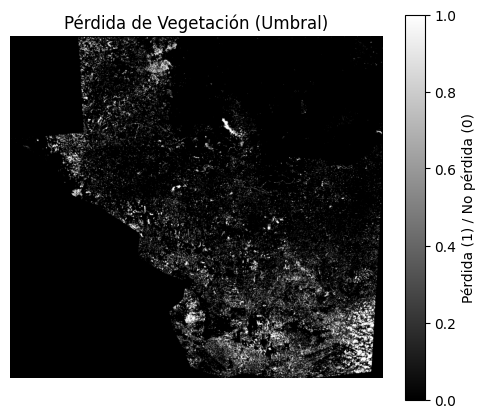

In [6]:
# Máscara de pérdida de vegetación
plt.figure(figsize=(6,5))
plt.imshow(perdida, cmap='gray')
plt.title("Pérdida de Vegetación (Umbral)")
plt.colorbar(label="Pérdida (1) / No pérdida (0)")
plt.axis('off')
plt.show()

## Área de deforestación

In [8]:
# Área de pixel (m²)
with rasterio.open("2020-04/2020-04-06-00_00_2020-04-19-23_59_Sentinel-2_L2A_B08_(Raw).tiff") as src:
    resol_x, resol_y = src.res
area_pixel = abs(resol_x * resol_y)

# Cálculo de área
pixeles_perdida = np.sum(perdida)
area_perdida_m2 = pixeles_perdida * area_pixel

# Porcentaje de pérdida
area_total_m2 = perdida.size * area_pixel
porcentaje_perdida = (area_perdida_m2 / area_total_m2) * 100

print(f"Área pérdida: {area_perdida_m2:.2f} m²")
print(f"Porcentaje pérdida: {porcentaje_perdida:.2f} %")

Área pérdida: 0.26 m²
Porcentaje pérdida: 5.93 %
